In [1]:
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
if tr.backends.mps.is_available():
    device = tr.device("mps")
else:
    print ("MPS device not found.")

In [3]:
mass = -0.2
lam = 0.5
Nd =2
mtil = mass +2 *Nd 
def action(phi):
        A = 0.5*mtil*tr.einsum('bxy,bxy->b',phi,phi) + (lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        for mu in range(1,Nd+1):
            A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))
        return A


In [4]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = tr.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = tr.nn.ModuleList([nets() for _ in range(len(masks))])
    
    # this is the forward start from noise target
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * tr.exp(s) + t)
        return x
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * tr.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    

In [5]:
L=8 # the length of the lattice which is going to be L x L torus
V=L*L # the volume

In [6]:
X = np.array(np.arange(L))[:,np.newaxis]
Y = np.array(np.arange(L))[np.newaxis,:]
#X = X[:,np.newaxis]

X = np.repeat(X,L,axis=1)
Y = np.repeat(Y,L,axis=0)
mm = (X+Y)%2
mm

array([[0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0]])

In [7]:
lm = mm.reshape(V)

In [8]:
tt = distributions.Normal(tr.zeros(V).to(device),tr.ones(V).to(device))
prior= distributions.Independent(tt, 1)
z = prior.sample((10,1)).squeeze()
z.shape
prior.log_prob(z)

tensor([-93.5850, -92.3877, -98.1501, -82.7220, -88.9402, -92.1699, -95.1642,
        -90.2449, -82.1901, -85.0990], device='mps:0')

In [9]:
# this are functions returning nets
#nets = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V), nn.Tanh())
#nett = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V))
nets = lambda: nn.Sequential(nn.Linear(V, 2*V), nn.LeakyReLU(), nn.Linear(2*V, V), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(V, 2*V), nn.LeakyReLU(), nn.Linear(2*V, V))


# the number of masks determines layers
masks = tr.from_numpy(np.array([lm, 1-lm] * 3).astype(np.float32))
normal = distributions.Normal(tr.zeros(V,device=device),tr.ones(V,device=device))
prior= distributions.Independent(normal, 1)
flow = RealNVP(nets, nett, masks, prior)
flow =flow.to(device)

In [10]:
batch_size = 2*2048
optimizer = tr.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
tic=time.perf_counter()
for t in range(5001):   
    #with torch.no_grad():
    z = prior.sample((batch_size, 1)).squeeze()
    x = flow.g(z) # generate a sample
    loss = (flow.log_prob(x)+action(x.view(batch_size,L,L))).mean() # KL divergence (or not?)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step() 
    if t % 500 == 0:
        toc=time.perf_counter()
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss,'time = %.3f' % (toc-tic),'seconds')
        tic=time.perf_counter()

NotImplementedError: The operator 'aten::roll' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [11]:
z = prior.sample((batch_size, 1)).squeeze()
x = flow.g(z)
x.shape
x,j = flow.f(z)
prior.log_prob(z).shape,j.shape

(torch.Size([4096]), torch.Size([4096]))

In [12]:
z = prior.sample((10, 1)).squeeze()
x = flow.g(z)

In [13]:
zz,j=flow.f(x)

In [14]:
print(zz.requires_grad,z.requires_grad)

True False


In [15]:
print(tr.sum(tr.abs(zz-z))/V)

tensor(3.7154e-06, device='mps:0', grad_fn=<DivBackward0>)


In [16]:
diff = action(x.view(x.shape[0],L,L))+flow.log_prob(x)
print(diff)

tensor([-25.2105, -25.3630, -25.6661, -24.1302, -25.2668, -24.6697, -24.6731,
        -23.7064, -24.4682, -24.3082], device='mps:0', grad_fn=<AddBackward0>)


In [17]:
print(diff - diff.mean())

tensor([-0.4643, -0.6168, -0.9199,  0.6161, -0.5205,  0.0765,  0.0731,  1.0399,
         0.2780,  0.4380], device='mps:0', grad_fn=<SubBackward0>)


In [18]:
z = prior.sample((2000, 1)).squeeze()
xz = flow.g(z).detach()
diff = action(xz.view(xz.shape[0],L,L))+flow.log_prob(xz)
diff.std()

tensor(0.6308, device='mps:0', grad_fn=<StdBackward0>)

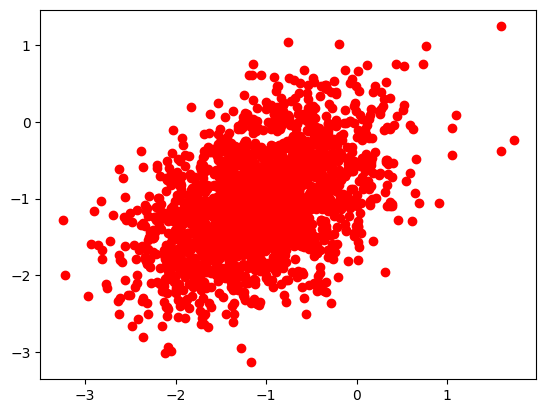

In [19]:
x = flow.sample(2000).detach().cpu().numpy()
plt.scatter(x[:, 0,0], x[:, 0,1], c='r')

In [20]:
m_diff = diff.mean()
diff -= m_diff

In [21]:
print("max  action diff: ", tr.max(diff.abs()).cpu().detach().numpy())
print("min  action diff: ", tr.min(diff.abs()).cpu().detach().numpy())
print("mean action diff: ", m_diff.detach().cpu().detach().numpy())
print("std  action diff: ", diff.std().cpu().detach().numpy())

max  action diff:  4.243637
min  action diff:  9.918213e-05
mean action diff:  -24.831303
std  action diff:  0.63078976


In [22]:
foo = tr.exp(-diff)
#print(foo)
w = foo/tr.mean(foo)

print("mean re-weighting factor: " , w.mean().cpu().detach().numpy())
print("std  re-weighting factor: " , w.std().cpu().detach().numpy())



mean re-weighting factor:  1.0
std  re-weighting factor:  0.80210304


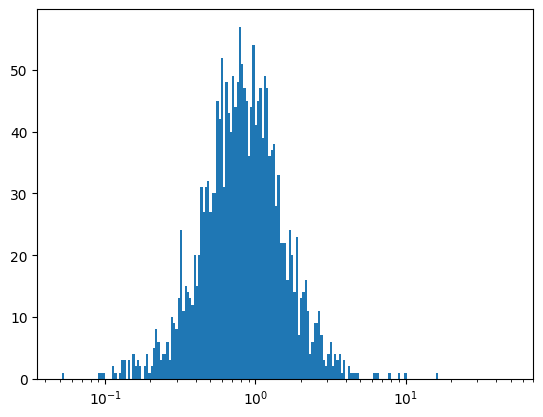

In [23]:
logbins = np.logspace(np.log10(5e-2),np.log10(5e1),int(w.shape[0]/10))
plt.hist(w.detach().cpu(),bins=logbins)
plt.xscale('log')

In [24]:
c=0
for tt in flow.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)

parameter count:  198912
